<a href="https://colab.research.google.com/github/sheliak/klasifikacija_spektrov/blob/main/klasifikacija.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Klasifikacija zvezdnih spektrov s strojnim učenjem

Delavnica za tabor Gimnazije Bežigrad, junij 2023

Seznam poglavij:

 - [Spoznajmo spektre](#spoznajmo-spektre)
 - [Metoda glavnih komponent](#pca)
 - [Nelinearne projekcije](#tsne)



Pred vami je vaja v obliki pythonovih zapiskov (Python notebook). Python je programski jezik, ki ga bomo uporabljali. Zapiski pa so narejeni v interaktivni obliki, kjer se prepletajo tekst, programska koda in grafi. Vaji je možno slediti brez znanja programiranja. Je pa pri tem še vseeno potrebno vse dele kode zagnati. To lahko naredimo s klikom na gumb "play" v zgornjem levem kotu okna s kodo ali pa v meniju Runtime > Run all. Če želite kodo spreminjati, jo morate po vsaki spremembi takisto zagnati.

Naš prvi korak bo, da zaženemo del kode, ki poskrbi za pravilno vključevanje knjižnic (že napisanih programov in ukazov, ki jih bomo uporabljali) in izvede nekaj nastavitev.

In [3]:
# Ta del kode naloži nekaj knjižnic (standardnih programov), na primer za
# risanje grafov (matplotlib) in za numerične operacije in funkcije (numpy) in
# nastavi nekaj parametrov.

%matplotlib inline
from ipywidgets import interactive, FloatSlider, Dropdown
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams["figure.figsize"] = (17, 8)
from IPython.display import display, clear_output
import urllib.request
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


<a id='spoznajmo spektre'></a>
## Spoznajmo spektre zvezd

### Mavrica

Svetloba je sestavljena iz različnih barv. Poleg tistih, ki smo jim dali imena, si lahko enostavno predstavljamo vse barve mavrice. Celotnega nabora barv ne moremo poimenovat, zato vsaki barvi pripišemo številko. Rekli ji bomo valovna dolžina. Bolj modre barve bodo imele valovno dolžino koli 400 nm (nanometrov), bolj rdeče pa okoli 700 nm. Vse barve mavrice pašejo nekam vmes. Manjše valovne dolžine predstavljajo nevidno ultravijolično svetlobo, večje pa infrardečo. Danes se s slednjima dvema deloma valovnih dolžin ne bomo ukvarjali. Koliko svetlobe opzimo pri različnih valovnih dolžinah imenujemo spekter.

Dajmo si valovne dolžine in spekter vizualizirat. Na voljo imamo nekaj spektrov zvezd z različnimi temperaturami od 3500 K do 40600 K. Naše Sonce ima na površju temperaturo 5800 K. Kateri spekter bi radi narisali lahko izberemo iz menija.

In [4]:
# Nalozimo datoteke

files_txt=['https://raw.githubusercontent.com/sheliak/klasifikacija_spektrov/main/primeri/O8_40600.txt',\
       'https://raw.githubusercontent.com/sheliak/klasifikacija_spektrov/main/primeri/B3_17600.txt',\
       'https://raw.githubusercontent.com/sheliak/klasifikacija_spektrov/main/primeri/A3_08750.txt',\
       'https://raw.githubusercontent.com/sheliak/klasifikacija_spektrov/main/primeri/F5_06700.txt',\
       'https://raw.githubusercontent.com/sheliak/klasifikacija_spektrov/main/primeri/G2_05800.txt',\
       'https://raw.githubusercontent.com/sheliak/klasifikacija_spektrov/main/primeri/K3_04800.txt',\
       'https://raw.githubusercontent.com/sheliak/klasifikacija_spektrov/main/primeri/M3_03500.txt']

files={40600: np.loadtxt(files_txt[0], comments='#', usecols=(0,1)),\
       17600: np.loadtxt(files_txt[1], comments='#', usecols=(0,1)),\
       8750: np.loadtxt(files_txt[2], comments='#', usecols=(0,1)),\
       6700: np.loadtxt(files_txt[3], comments='#', usecols=(0,1)),\
       5800: np.loadtxt(files_txt[4], comments='#', usecols=(0,1)),\
       4800: np.loadtxt(files_txt[5], comments='#', usecols=(0,1)),\
       3500: np.loadtxt(files_txt[6], comments='#', usecols=(0,1))}

Dropdown(description='Temperatura:', index=5, options=('3500 K', '4800 K', '5800 K', '6700 K', '8750 K', '1760…

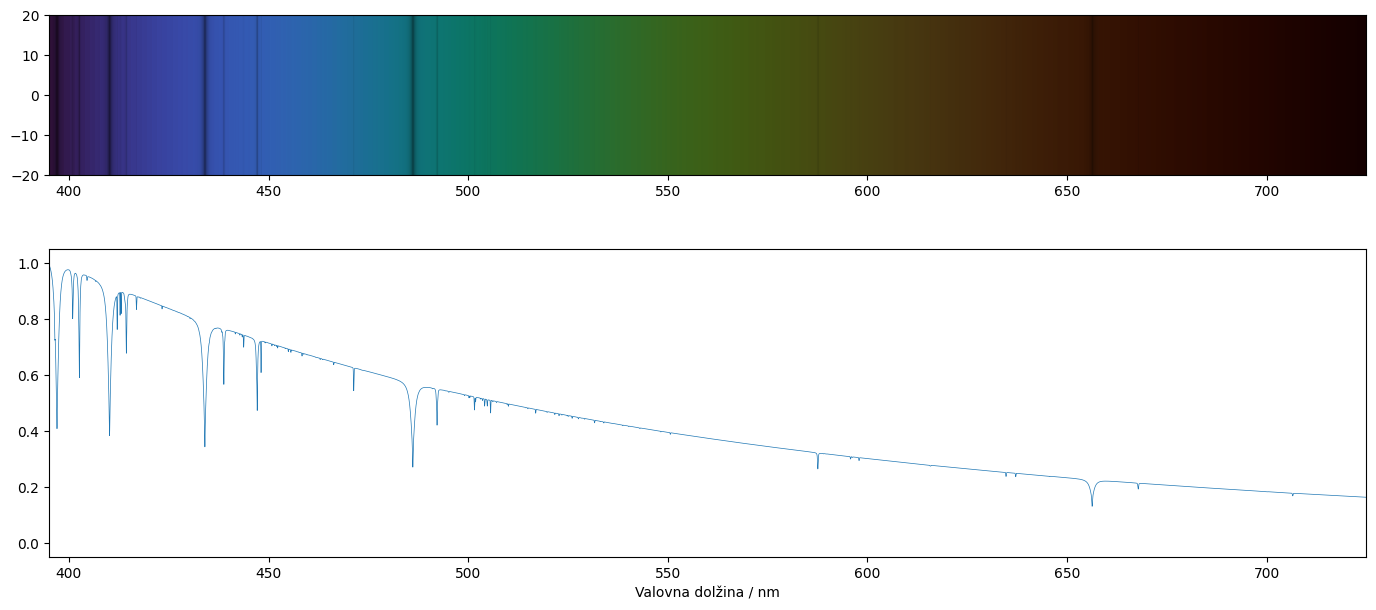

In [5]:
# Konstante, ki jih potrebujemo za izračun Planckove funkcije
c=3*10**8
p=3.1416
h=6.626*10**-34
k=1.38*10**-23
d=0.5*10**-1
A=2*c*c*h

def planck(x,t):
    # Planckova funkcija za telo s temperaturo t pri valovnih dolzinah x
    return ((A)/(((x*10**-9)**5)*(np.exp(((h*c)/(t*k))/(x*10**-9))-1)))

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output()
        display(menu)
        fig=plt.figure(1)
        fig.subplots_adjust(hspace=0)
        ax1=fig.add_subplot(211)
        s=files[int(change['new'].split()[0])]
        l=s[:,0] # valovna dolzina
        w=s[:,1] # normaliziran flux
        t=int(change['new'].split()[0]) # temperatura
        wp=w*planck(l,t) # pravi flux
        wp=wp/max(wp) # pravi flux brez enot

        cmap_b=colors.LinearSegmentedColormap.from_list('cmap_b', ['k', 'k'])
        ax1.imshow(np.expand_dims(l, axis=0),cmap='turbo',extent=[l.min(), l.max(), -20,20],)
        ax1.imshow(np.expand_dims(wp, axis=0),alpha=np.expand_dims(1-wp, axis=0), cmap=cmap_b, extent=[l.min(), l.max(), -20,20],)
        ax2=fig.add_subplot(212, sharex=ax1)
        ax2.plot(l,wp, lw=0.5)
        ax2.set_xlabel('Valovna dolžina / nm')
        plt.show()

menu = Dropdown(options=['3500 K', '4800 K', '5800 K', '6700 K', '8750 K', '17600 K', '40600 K'], value='5800 K', description='Temperatura:')
menu.observe(on_change, names='value')
display(menu)


Ko narišemo spekter neke zvezde se nam najprej izriše "mavrica", kjer imamo tudi označene valovne dolžine, ki pripadajo vsem barvam.

Prva stvar, ki jo opazimo je, da določene valovne dolžine v spektru manjkajo ali pa so temnejše. Za to so odgovorni atomi kemičnih elementov v atmosferi zvezd, ki določene valovne dolžine absorbirajo. V zvezdah je največ vodika, ki absorbira valovno dolžino pri 656 nm. Strukturi v spektru, k ijo to povzroči rečemo spektralna črta. Vendar to ni edini faktor, ki vpliva na moč črt. Če je zvezda vroča, je več atomov ioniziranih (razbitih na jedra in ločene elektrone), ki ne morejo basorbirat svetlobe. To lepo vidimo, če narišemo spekter bolj vroče zvezde.

Navadno spektra zvezde ne narišemo v mavričnih barvah, ampak narišemo graf, ki kaže kako se svetlost zgornje mavrice spreminja z valovnimi dolžinami. Na tem grafu tudi lepo vidimo, da vroče zvezde več svetlobe izsevajo v modrih valovnih dolžinah, hladne pa več v rdečih. V nadaljevanju naloge nas bo zanimalo samo obnašanje spektralnih črt, zato bomo globalni trend iz spektrov odstranili. Poskusi spremeniti zgornjo kodo tako, da se bo na graf narisala le relativna svetlost brez upoštevanja globalnega trenda.

###Spektri zvezd pri tej vaji

Pri tej vaji se ne bomo ukvarjali s celimi spektri zvezd, ampak bomo uporabili le majhen nabor valovnih dolžin med 655.0 nm in 667.5 nm. Prvi razlog je, da cele spektre redko posnamemo ampak se skoncentriramo na tiste dele valovnih dolžin, ki so zanimivi ali pomembni. Drugi razlog je, da bi naši programi delali veliko prepočasi, če bi uporabili celoten spekter.

Za to vajo imamo na voljo spektre 10 000 različnih zvezd, ki jih je posnel pregled neba GALAH. Za 52 od teh zvezd imamo podane tudi podatke o temperaturi zvezde, gravitacijskem pospešku na njenem površju in zastopanost kovin v zvezdini atmosferi. Za ostale zvezde so ti parametri še neznani. Za 56 zvezd imamo podane njihove tipe (glej sledečo tabelo). Za ostale zvezde prav tako ne vemo kakšnih tipov so.

| Kratica | Tip zvezde | Lastnost |
| --- | --- | --- |
| MAB | Zvezde z molekularnimi črtami | V hladnejših zvezdah lahko preživijo preproste molekule, kot sta TiO in CN. te vidimo kot široke serije absorpcijskih črt ali pasov. |
| BIN | Dvojne zvezde | Zajeli smo svetlobo dveh zvezd in zato vidimo seštevek spektrov dveh zvezd. |
| TRI | Trojne zvezde | Vidimo seštevek treh spektrov treh zvezd. Posamezne zvezde so lahko različnih tipov. |
| HFR | Vroče, hitro se vrteče zvezde | Spektralne črte so močno razširjene. Šibkejših črt zato ne vidimo.|
| HAE | Spektri z emisijo v vodikovi H alpha črti. | Namesto absorpcijske črte vidimo emisijsko črto pri okoli 656 nm. Ali pa kombinacijo emisijske in absorpcijske črte.  |
| CMP | Hladne zvezde z malo kovinami | Absorpcijske črte kovin so šibke. Prav tako vodikova črta, saj so te zvezde hladne.|
| DIB | Prisotnost medzvezdnih absorpcijskih črt | Plin v prostoru med nami in zvezdo je dodal svoje absorpcijske črte, na primer okoli 661 nm. |

Za nekaj zvezd z znanimi tipi ali parametri narišimo njihov spekter. Številka spektra z znanim tipom ali parametri je podana v prvem stolpcu datotek `ucni_set_tipi.txt` in `ucni_set_parametri.txt`.

(6550.0, 6674.98)

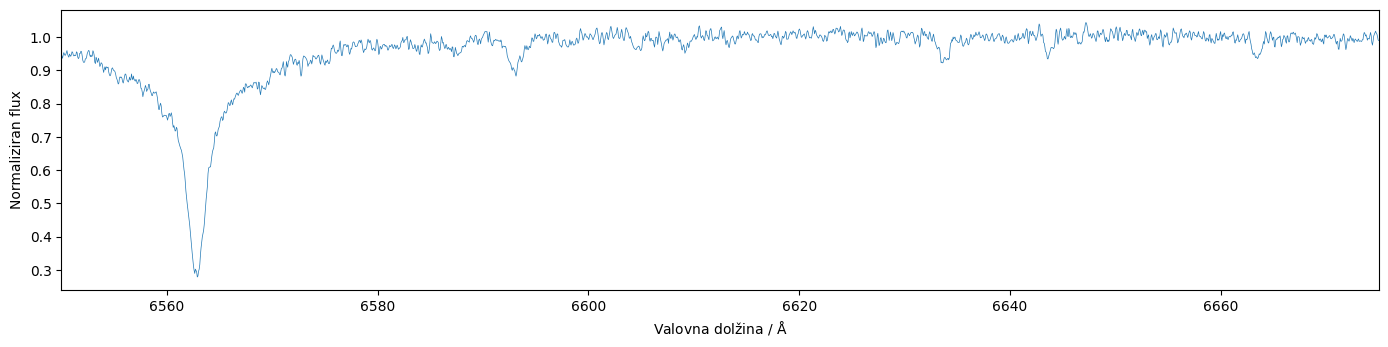

In [6]:
# Naredimo slovar tipov

tipi={}
for line in urllib.request.urlopen('https://raw.githubusercontent.com/sheliak/klasifikacija_spektrov/main/podatki/ucni_set_tipi.txt'):
    line=line.decode('utf-8')
    if line[0]=='#': continue
    spekter, tip = line.split()
    if tip in tipi:
        tipi[tip].append(spekter)
    else:
        tipi[tip]=[spekter]

# Narisimo spekter nekega tipa ('MAB', 'BIN', 'TRI', 'HFR', 'HAE', 'CMP', 'DIB')

spekter=tipi['HFR'][0]
l=np.loadtxt('https://raw.githubusercontent.com/sheliak/klasifikacija_spektrov/main/podatki/spektri/val.dat') # seznam valovnih dolzin
w = np.loadtxt('https://raw.githubusercontent.com/sheliak/klasifikacija_spektrov/main/podatki/spektri/%s.dat' % spekter) # flux

fig=plt.figure(2)
ax=fig.add_subplot(211)
ax.plot(l,w,lw=0.5)
ax.set_xlabel('Valovna dolžina / $\mathrm{\AA}$')
ax.set_ylabel('Normaliziran flux')
ax.set_xlim(l[0], l[-1])

Narišimo raje vse spektre znanih tipov in raziščimo njihovo morfologijo. Tip spektra lahko izbereš iz menija, z drsnikom pa izbereš kateri od spektrov tega tipa bo povdarjen.

In [7]:
# Narisimo vse spektre nekega tipa

def plot_all(spekter_bold=0):
    #spekter_bold pove kateri spekter iz enega tipa naj bo povdarjen
    fig=plt.figure(3)
    ax=fig.add_subplot(211)

    tip=menu.value #kateri tip risem

    spectra=[]
    #narisi vse spektre v sivem
    ax.cla()
    for spekter in tipi[tip]:
        w = np.loadtxt('https://raw.githubusercontent.com/sheliak/klasifikacija_spektrov/main/podatki/spektri/%s.dat' % spekter)
        spectra.append(w)
        ax.plot(l,w,lw=0.6, alpha=0.2, c='k')
    #narisi povdarjen spekter
    ax.plot(l,spectra[spekter_bold], lw=0.6, alpha=1, c='r')
    ax.set_xlabel('Valovna dolžina / $\mathrm{\AA}$')
    ax.set_ylabel('Normaliziran flux')
    ax.set_title('Spekter # '+tipi[tip][spekter_bold])
    ax.set_xlim(l[0], l[-1])
    plt.show()

def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output()
        display(menu)
        w=interactive(plot_all, spekter_bold=(0,len(tipi[menu.value])-1,1))
        display(w)

menu = Dropdown(options=['MAB', 'BIN', 'TRI', 'HFR', 'HAE', 'CMP', 'DIB'], value='MAB', description='Tip:')
menu.observe(on_change, names='value')
display(menu)

w=interactive(plot_all, spekter_bold=(0,len(tipi[menu.value])-1,1))
w


Dropdown(description='Tip:', index=3, options=('MAB', 'BIN', 'TRI', 'HFR', 'HAE', 'CMP', 'DIB'), value='HFR')

interactive(children=(IntSlider(value=0, description='spekter_bold', max=7), Output()), _dom_classes=('widget-…

Vidimo, da v večini primerov brez učnega seta sploh ne moremo ugotoviti, kakšnega tipa so te zvezde. Na primer, večina dvojnih zvezd nima podvojenih črt. Vidimo le eno od komponent, ali pa so črte primarne in sekundarne zvezde zlite skupaj. V spektrih, kjer naj bi bile prisotne molekulske črte le-teh ne vidimo. Vročih in hitro vrtečih zvezd ne moremo ločiti med sabo ...

Katerega tipa so zvezde bo veliko bolje od naših uči ugotovil računalnik.

<a id='pca'></a>
## Metoda glavnih komponent

### Projekcije dimenzij

Mogoče ste že ugotovili, da imajo vsi naši spektri podan fluks pri istih 2084 valovnih dolžinah v konstantnih korakih 0.006 nm. Temu rečemo vzorčenje. Posledično je vsak spekter podan le z 2084 vrednostmi fluksa pri vsaki valovni dolžini, za razlike med spektri pa sama valovna dolžina ne bo pomembna. Sedaj bomo vsak spekter predstavili kot točko v 2084 dimenzionalnem prostoru ali kot vektor v 2084 dimenzionalnem prostoru. To si je mogoče težko predstavljati, vendar računalniki so prilagojeni delu z vektorji v visokodimenzionalnih prostorih.

Za boljšo predstavo postavimo spektre na stran in si poglejmo set podatkov, kjer ima vsaka točka le dve koordinati (v 2D prostoru). To bi bilo analogno spektru, kjer bi imeli fluks podan pri le dveh valovnih dolžinah.

Generirali bomo naključne podatke in jih narisali v dveh dimenzijah.

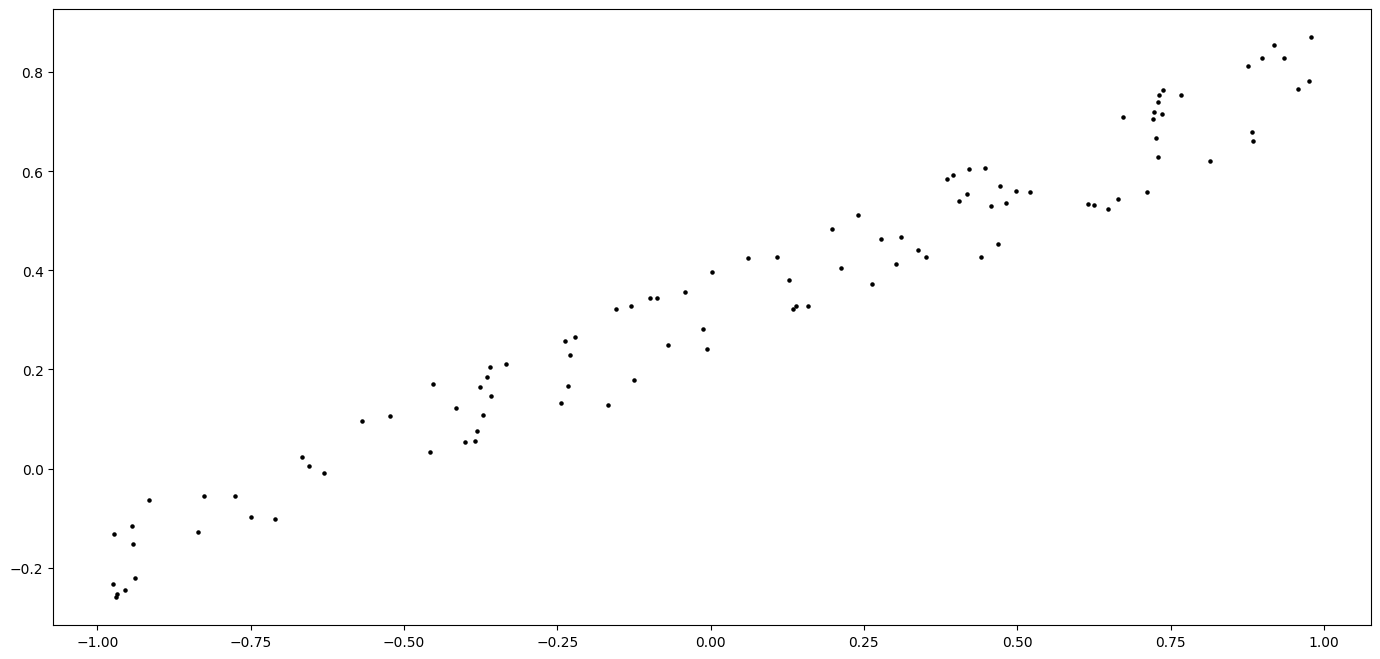

In [8]:
# Generirajmo 2D podatke

x=np.random.rand(100)*2-1
y=0.5*x+0.3+np.random.rand(100)*0.2-0.1

fig=plt.figure(4)
ax=fig.add_subplot(111)
ax.scatter(x,y,s=5,c='k')
plt.show()

Vidimo, da vzgornjem primeru vse točke ležijo vzdolž neke premice z relativno majhno razsutostjo. Izberimo si dve točki. Da lahko povemo kako sta si podobni ali različni, moramo vsako točko opisati z dvema koordinatama. Ampak relacijo med obema točkama prav dobro opišemo, če povemo le kako daleč narazen sta si vzdolž premice.

Izračunamo lahko projekcijo točk na premico. Pozicijo vsake točke na tej premici bomo sedaj lahko podali z le eno koordinato. Dimenzijo naših podatkov smo tako zreducirali iz dveh na eno. Pri tem so se (v večji meri) ohranile relacije med točkami: dve točki, ki sta bili daleč narazen v 2D prostoru sta daleč narazen tudi v 1D prostoru.

Predstavimo to na interaktivnem grafu. Narisali bomo točke, premico na katero jih bomo projecirali in rezultat projekcije (1D pozicija projekcije na premici). Za skoraj vsak par točk lahko relacijo med njima opišemo zgolj v eni dimenziji. S premikanjem drsnikov lahko najdeš točki A in B, kjer to ne bo povsem res.

In [9]:
def plot_me(pa=0, pb=1):
    global x
    global y
    fig=plt.figure(5)
    ax=fig.add_subplot(111)
    ax.scatter(x,y,s=5,c='k')
    ax.plot(x[pa],y[pa],'ro')
    ax.text(x[pa], y[pa], ' A', c='r')
    ax.plot(x[pb], y[pb], 'ro')
    ax.text(x[pb], y[pb], ' B', c='r')
    xx=np.linspace(-1,1)
    yy=0.5*xx+0.3
    ax.plot(xx,yy)

    # Projecirajmo tocke na premico
    premica=[1,0.5] # vektor, ki podaja premico
    xn=x-np.average(x)
    yn=y-0.3
    projekcija=[np.dot(premica, [i, j])/np.sqrt(1+0.5**2) for i,j in zip(xn,yn)]
    fig=plt.figure(6)
    ax=fig.add_subplot(311)
    ax.scatter(projekcija, [0]*len(projekcija),s=5,c='k')
    ax.plot(projekcija[pa], 0,'ro')
    ax.text(projekcija[pa], 0, ' A', c='r')
    ax.plot(projekcija[pb], 0, 'ro')
    ax.text(projekcija[pb], 0, ' B', c='r')
    plt.show()

w=interactive(plot_me, pa=(0,100,1), pb=(0,100,1))
w

interactive(children=(IntSlider(value=0, description='pa'), IntSlider(value=1, description='pb'), Output()), _…

Cilj te naloge je na podoben način zreducirati naš 2084 dimenzionalni prostor na 2D prostor, kjer lahko položaj vsakega spektra še vedno predstavimo s točko v dveh dimenzijah. Če lahko projekcije naredimo na tak način, da se bodo relacije med točkami v 2084D prostoru čim bolje ujemale z relacijami med točkami v 2D prostoru, bomo lahko sklepali, da so spektri na istem delu 2D ravnine podobni.

V praksi seveda ne vemo vzdolž katere ravnine moramo narediti projekcijo. To lahko ugotovimo z metodo glavnih komponent (ang. Principal component analysis - PCA). Rezultat tega algoritma bodo projecirane koordinate točk, kjer so koordinate urejene po pomembnosti. Prva komponenta vektorja nosi največ informacije, druga manj in tako dalje. Če želimo vizualizirati mnogodimenzionalni prostor z le dvema koordinatama, bomo seveda ohranili le prvi dve komponenti, ki nosita največ informacije. Ker računalnik ne ve katero informacijo mi v resnici iščemo, oziroma katera karakteristika spektrov naz zanima, to ni nujno najbolj optimalna projekcija za naše potrebe.

Ker je projekcija v manj dimenzionalni prostor linearna, lahko projecirane koordinate predstavljajo neko fizikalno količino. V praksi je težko ugotoviti katero, oziroma bi bila tovrstna fizikalna količina nepomembna.

Poglejmo najprej ali metoda PCA da pričakovan rezultat za naš preprost sistem 2D podatkov. Naredimo PCA redukcijo iz dveh dimenzij v eno:

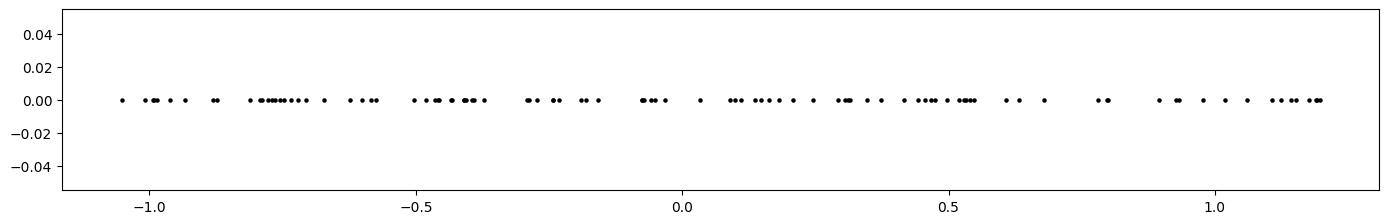

In [10]:
pca = PCA(n_components=1) #nastavimo parametre metode PCA
pca.fit(np.array([x,y]).T) #izračunamo lastne vektorje in lastne vrednosti
projekcija=pca.transform(np.array([x,y]).T) #iz lastnih vektorjev in vrednosti naredimo projekcijo

fig=plt.figure(7)
ax=fig.add_subplot(311)
ax.scatter(projekcija, [0]*len(projekcija),s=5,c='k')
plt.show()

Ali je rezultat metode PCA enak tistemu, ki smo ga dobili, ko smo sami izračunali projekcijo točk na premico?

### Projekcije spektrov

Odprimo sedaj vse spektre in naredimo njihovo projekcijo iz 2084 dimenzij v dve. Sledeči ukaz v spomin naloži vse spektre. Ker prenaša enega po enega iz github-a, ta del lahko traja.

In [11]:
#Nalozimo vse spektre (lahko traja)
spektri=[]
l=np.loadtxt('https://raw.githubusercontent.com/sheliak/klasifikacija_spektrov/main/podatki/spektri/val.dat') # seznam valovnih dolzin
for i in range(1,5500,1):
    print('Procesiram spekter st. %s' % i, end='')
    w = np.loadtxt('https://raw.githubusercontent.com/sheliak/klasifikacija_spektrov/main/podatki/spektri/%s.dat' % i) # flux
    spektri.append(w)
    print('\r', end='')

#Pretvorimo seznam v array
spektri=np.array(spektri)



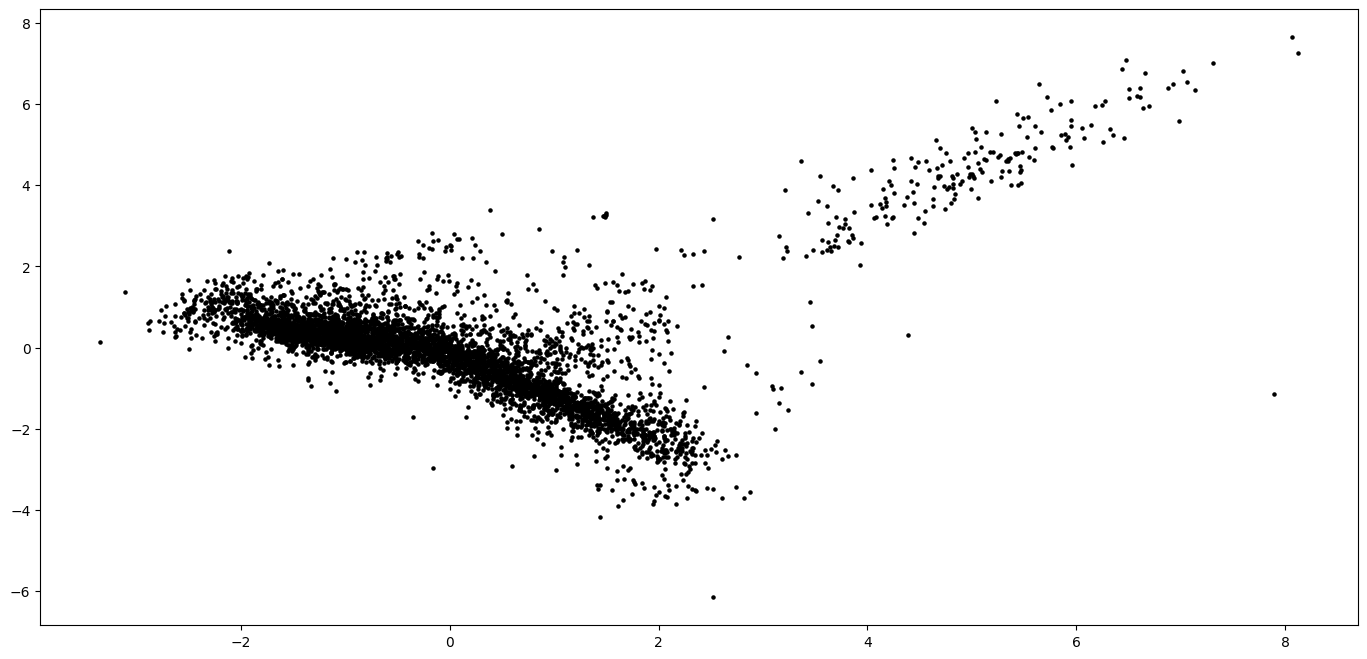

In [12]:
#Naredimo projekcijo
pca = PCA(n_components=2)
pca.fit(spektri)
projekcija=pca.transform(spektri)

#Narisemo 2D ravnino
fig=plt.figure(8)
ax=fig.add_subplot(111)
ax.scatter(projekcija[:,0], projekcija[:,1], s=5, c='k')
plt.show()

Vidimo, da v projecirani ravnini lahko prepoznamo vsaj dve skupini točk, ki predstavljata spektre z dvema močno različnima lastnostima. Z nekaj domišljije si lahko zamislimo še druge skupine, ki pa niso dobro ločene od glavnine točk.

Označimo na tej sliki vse spektre, za katere vemo katerega tipa so. SPodnja koda najprej spremeni obnašanje tega dokumenta in omogoči nekaj več interakcije.

In [13]:
!pip -q install ipympl
from google.colab import output
output.enable_custom_widget_manager()
%matplotlib ipympl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.6/511.6 kB 17.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.1 MB/s eta 0:00:00


Spodaj narišemo isto ravnino točk, z barvami in tekstom označimo spektre znanih tipov in omogočimo klik na točko, tako da se bo narisal njej pripadajoč spekter.

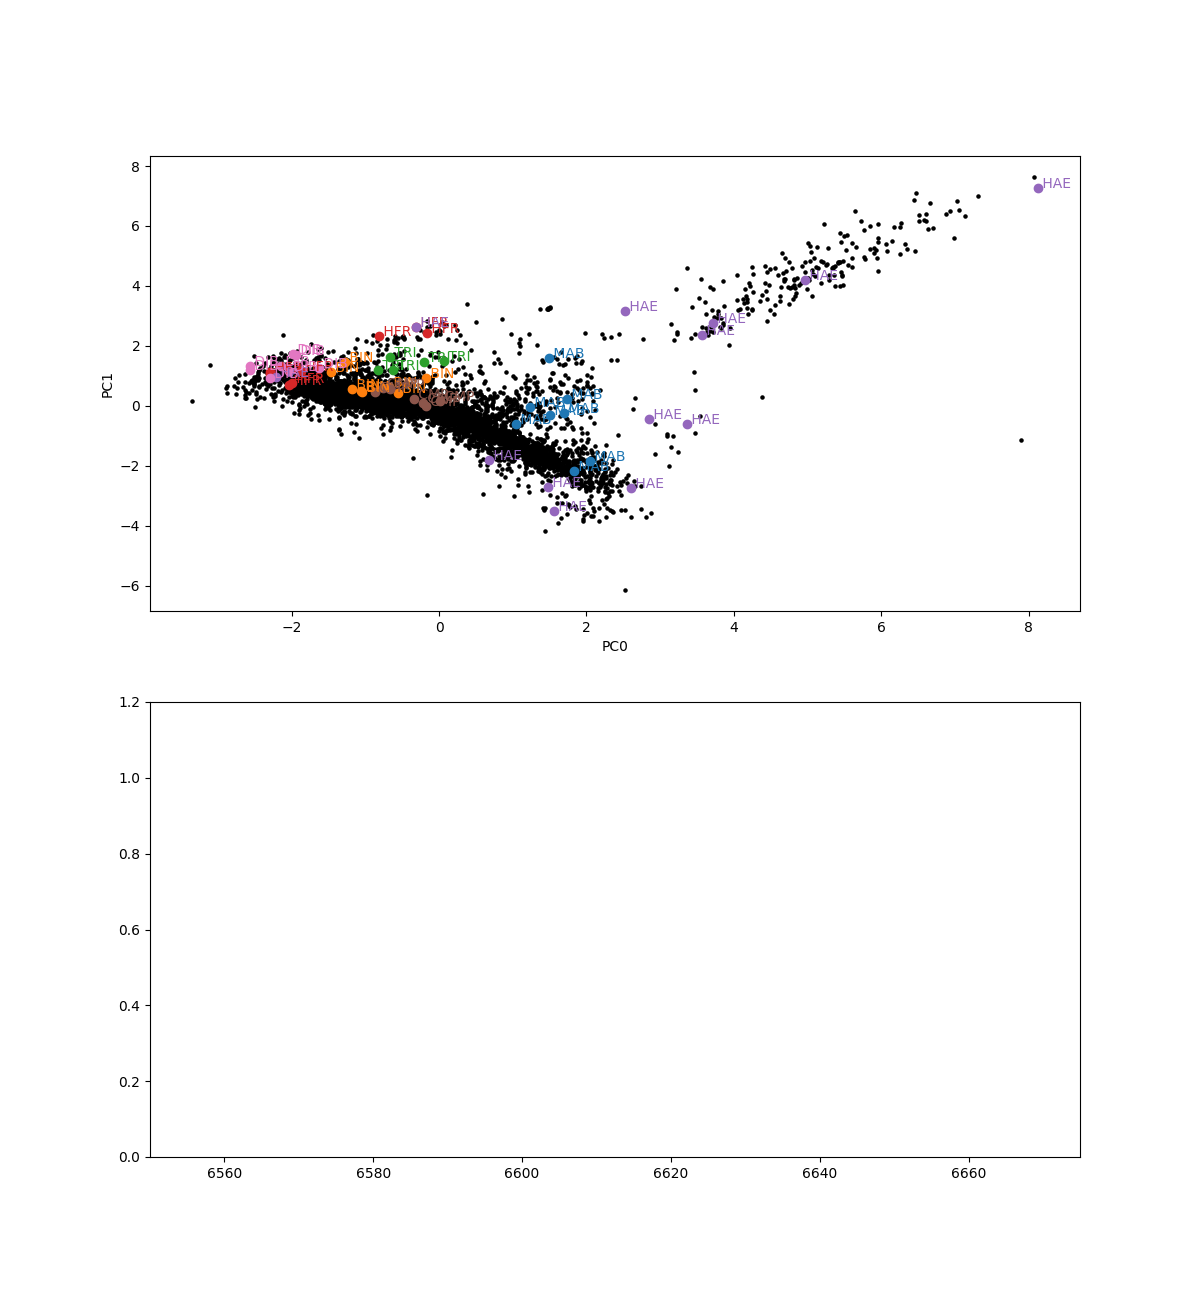

In [14]:
def onpick(event):
    ind = event.ind[0]
    line.set_ydata(spektri[ind])
    fig.canvas.draw()
    fig.canvas.flush_events()

#Naredimo projekcijo
pca = PCA(n_components=2)
pca.fit(spektri)
projekcija=pca.transform(spektri)

#Narisemo 2D ravnino
fig=plt.figure(11, figsize=(12,13))
ax=fig.add_subplot(211)
ax_s=fig.add_subplot(212)

line,=ax_s.plot(l, [-1]*len(l), 'k-')
ax_s.set_xlim(l[0],l[-1])
ax_s.set_ylim(0,1.2)
ax.set_xlabel('Valovna dolžina / $\\mathrm{\\AA}$')
ax.set_ylabel('Normaliziran fluks')

ax.scatter(projekcija[:,0], projekcija[:,1], s=5, c='k', picker=3)
ax.set_xlabel('PC0')
ax.set_ylabel('PC1')

fig.canvas.mpl_connect('pick_event', onpick)

#Dodamo oznake za zvezde iz ucnega seta ('MAB', 'BIN', 'TRI', 'HFR', 'HAE', 'CMP', 'DIB')

for n,tip in enumerate(['MAB', 'BIN', 'TRI', 'HFR', 'HAE', 'CMP', 'DIB']):
    indexes=tipi[tip]
    for i in indexes:
        ax.plot(projekcija[:,0][int(i)-1], projekcija[:,1][int(i)-1], marker='o', c='C%s' % n)
        ax.text(projekcija[:,0][int(i)-1], projekcija[:,1][int(i)-1], ' '+tip, c='C%s' % n)

plt.show()

Narišimo isto stvar, kjer z barvami označimo fizikalne parametre zvezd.

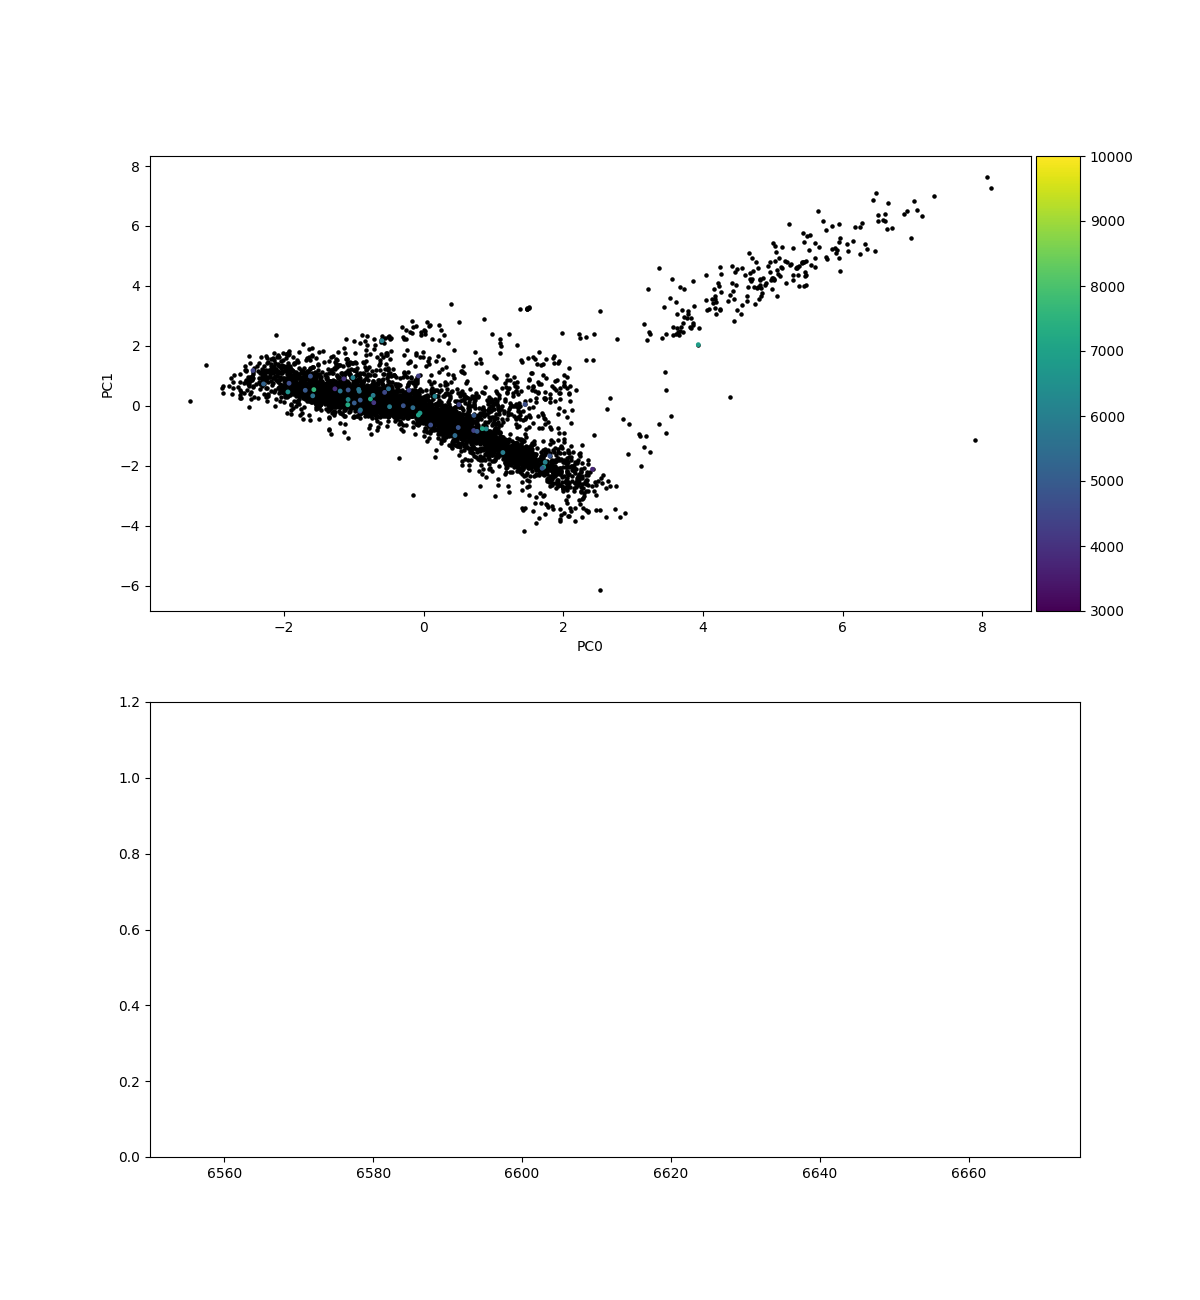

In [15]:
def onpick(event):
    ind = event.ind[0]
    line.set_ydata(spektri[ind])
    fig.canvas.draw()
    fig.canvas.flush_events()

# Odprimo datoteko z zvezdnimi parametri
spektri_s=[]
teff=[]
logg=[]
met=[]
for line in urllib.request.urlopen('https://raw.githubusercontent.com/sheliak/klasifikacija_spektrov/main/podatki/ucni_set_parametri.txt'):
    line=line.decode('utf-8')
    if line[0]=='#': continue
    line=line.split()
    spektri_s.append(int(line[0]))
    teff.append(float(line[1]))
    logg.append(float(line[2]))
    met.append(float(line[3]))

spektri_s=np.array(spektri_s)

#Naredimo projekcijo
pca = PCA(n_components=2)
pca.fit(spektri)
projekcija=pca.transform(spektri)

#Narisemo 2D ravnino
fig=plt.figure(12, figsize=(12,13))
ax=fig.add_subplot(211)
ax_s=fig.add_subplot(212)

line,=ax_s.plot(l, [-1]*len(l), 'k-')
ax_s.set_xlim(l[0],l[-1])
ax_s.set_ylim(0,1.2)
ax.set_xlabel('Valovna dolžina / $\\mathrm{\\AA}$')
ax.set_ylabel('Normaliziran fluks')

ax.scatter(projekcija[:,0], projekcija[:,1], s=5, c='k', picker=3)
im=ax.scatter(projekcija[:,0][spektri_s], projekcija[:,1][spektri_s], s=6, c=teff, vmin=3000, vmax=10000)
ax.set_xlabel('PC0')
ax.set_ylabel('PC1')

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

fig.canvas.mpl_connect('pick_event', onpick)

plt.show()

Katere zvezde lahko ločimo od ostalih?

Ali lahko s položajem v 2D ravnini določimo katerega od fizikalnih parametrov?

Zakaj ne moremo ločiti zvezd v največji skupini, če lahko vidimo očitne razlike med njihovimi spektri?

Kaj predstavljajo točke, ki najbolj odstopajo od glavnih skupin?

<a id='tsne'></a>
## Nelinearne projekcije

V praksi se podatki le redko uredijo vzdolž premic ali ravnin, zato linearne projekcije navadno ne ohranjajo relacij med točkami v mnogodimenzionalnem prostoru in 2D prostoru. Poslužiti se moramo nelinearnih projekcij. Spoznali bomo metodo t-distributed stohastic neigbour embedding (t-SNE).

Nelinearne metode za vsako točko v originalnem prostoru ugotovijo kakšna je njihova relacija glede na njihove najbližje sosede. Potem sestavijo prostor nižjih dimenzij in ga poselijo s točkami tako, da se podobnosti med sosedi najbolje ohranjajo. Že računanje podobnosti med točkami je počasna in zahtevna operacija. Najti optimalno projekcijo terja veliko poskušanja. Nelinearne metode so zato veliko počasnejše od linearnih.

V knjižnici `sklearn` imamo na voljo metodo TSNE. Koda za naredit projekcijo izgleda podobno kot v primeru za PCA.

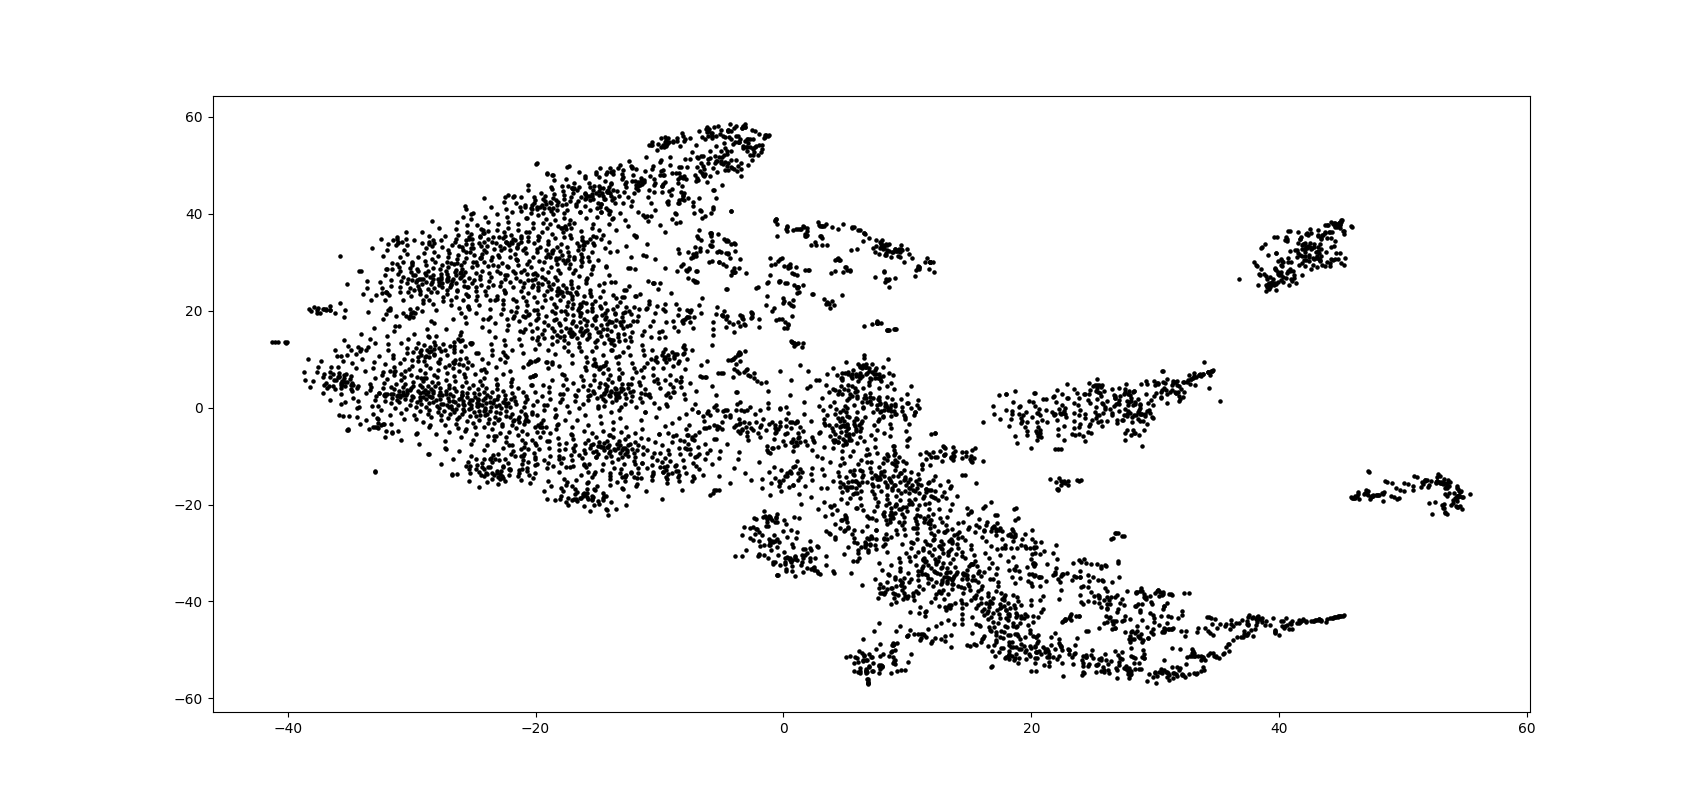

In [16]:
#Naredimo projekcijo
tsne = TSNE(n_components=2, perplexity=30)
#tsne.fit(spektri)
projekcija=tsne.fit_transform(spektri)

#Narisemo 2D ravnino
fig=plt.figure(13)
ax=fig.add_subplot(111)
ax.scatter(projekcija[:,0], projekcija[:,1], s=5, c='k')
plt.show()

Vidimo, da se točke uredijo v več skupin, ki so med sabo tudi bolj ločene kot v primeru za PCA. Spremeni zgornjo kodo tako, da dodas oznake za zvezde znanih tipov in preveri ali imajo skupine smisel.

Poskusi ugotoviti kaj predstavljajo skupine v katerih ni nobenega spektra iz učnega seta.

Narišimo še projekcijo v tri dimenzije. Toliko dimenzij še znamo zvizualizirati. Spremeniti moramo nastavitev classa TSNE, da bo pisalo `n_components=3`. Uporabili bomo tudi drugo knjižnico za risanje grafov, saj je matplotlib narejen predvsem za 2D risanje.

In [17]:
import plotly.graph_objs as go
import plotly.io as pio
pio.renderers.default = 'colab'

# Naredimo projekcijo
tsne = TSNE(n_components=3, perplexity=30)
projekcija=tsne.fit_transform(spektri)

trace = go.Scatter3d(x = projekcija[:,0], y = projekcija[:,1], z = projekcija[:,2], mode = 'markers', marker = dict(size = 2), opacity=0.7)

layout = go.Layout(width=1000, height=1000)
fig = go.Figure(data = [trace], layout=layout)
fig.show()